# Training the Neural Network on the Merged Dataframe

In [282]:
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers, utils, backend as K
import numpy as np
import shap
import tensorflow as tf
import pandas as pd
import tensorflow_addons as tfa


## Preparing the MENA Dataframe 

In [69]:
df_MENA = pd.read_csv("merged_dfs_MENA.csv")

#removing the columns with too many null valuse
df_MENA = df_MENA.drop(["SI.POV.MDIM.XQ", "SH.MED.CMHW.P3", "SH.MED.NUMW.P3","SI.POV.MDIM", "SI.POV.MDIM.IT","SL.WAG.0714.ZS"], axis = 1)
df_MENA_clean = df_MENA.interpolate().dropna()

#removing non numerical columns:
df_MENA_clean = df_MENA_clean.drop(["year","month","date","Unnamed: 0.1","Unnamed: 0_x","code","country_x", "geo_x", "country_code","Unnamed: 0_y","Country","Time","geo_y","economy","Unnamed: 0","iso3","country_y"], axis=1)
df_MENA_clean.head(10)

,protest,revolution,riots,strike,unrest,violence,BN.CAB.XOKA.GD.ZS,BX.KLT.DINV.WD.GD.ZS,EG.CFT.ACCS.ZS,EG.ELC.ACCS.ZS,EN.ATM.CO2E.PP.GD.KD,EN.POP.DNST,EN.POP.SLUM.UR.ZS,EN.URB.LCTY,EN.URB.MCTY.TL.ZS,FR.INR.LNDP,FR.INR.RINR,FX.OWN.TOTL.40.ZS,GC.DOD.TOTL.GD.ZS,GC.TAX.TOTL.GD.ZS,GC.XPN.INTP.RV.ZS,MS.MIL.XPND.GD.ZS,NY.GDP.DEFL.KD.ZG,NY.GDP.MKTP.KD,NY.GDP.PCAP.KD,PA.NUS.FCRF,PA.NUS.PPPC.RF,PX.REX.REER,SE.ADT.1524.LT.FM.ZS,SE.ADT.1524.LT.ZS,SE.ADT.LITR.ZS,SE.ENR.PRSC.FM.ZS,SE.TER.CUAT.BA.FE.ZS,SE.TER.CUAT.BA.MA.ZS,SE.TER.CUAT.BA.ZS,SH.H2O.BASW.ZS,SH.MED.BEDS.ZS,SH.MED.PHYS.ZS,SH.STA.BASS.ZS,SH.XPD.CHEX.PP.CD,SI.DST.10TH.10,SI.DST.FRST.10,SI.POV.GINI,SI.POV.LMIC.GP,SL.UEM.1524.FE.ZS,SL.UEM.1524.MA.ZS,SL.UEM.INTM.ZS,SL.UEM.TOTL.ZS,SM.POP.TOTL.ZS,SN.ITK.MSFI.ZS,SP.DYN.LE00.FE.IN,SP.DYN.LE00.MA.IN,SP.URB.TOTL.IN.ZS,ST.INT.ARVL,ST.INT.DPRT,unrest_index
186,0.0,5.0,0.0,26.0,1.0,3.0,-16.289765,-0.324012,99.500000,99.186661,0.336284,16.602626,24.98121,2.592330e+06,6.555699,6.25,15.453259,36.97,27.853317,1.791796,1.449801,6.270243,-6.455650,1.659793e+11,4197.421361,100.691433,0.347704,96.574336,0.95815,93.767326,75.136047,0.9949,19.861327,12.479951,14.952974,93.409562,1.9,1.195800,86.742524,838.510315,22.9,4.0,27.6,0.8,44.583000,27.049999,22.43,11.210000,0.611072,22.900000,76.82400,74.45600,70.848000,1.710000e+06,3.638000e+06,0.070350
187,0.5,4.0,0.0,20.0,0.0,5.0,-16.296788,-0.211703,99.508333,99.200293,0.335179,16.630482,24.65576,2.595106e+06,6.551797,6.25,14.694881,36.97,27.842586,1.774955,1.436024,6.279800,-5.788606,1.664219e+11,4201.489878,101.420736,0.347021,96.491564,0.95815,93.767326,75.136047,0.9949,19.800775,12.439813,14.906779,93.427330,1.9,1.248858,86.731104,832.640823,22.9,4.0,27.6,0.8,44.503917,26.657833,22.43,11.125833,0.611072,22.783333,76.82225,74.47575,70.898917,1.737417e+06,3.712333e+06,0.116459
188,0.0,4.0,0.0,20.0,0.0,4.0,-16.303810,-0.099394,99.516667,99.213926,0.334073,16.658339,24.33031,2.597881e+06,6.547895,6.25,13.936503,36.97,27.831856,1.758115,1.422248,6.289357,-5.121562,1.668645e+11,4205.558395,102.150039,0.346337,96.408793,0.95815,93.767326,75.136047,0.9949,19.740222,12.399674,14.860583,93.445098,1.9,1.301917,86.719684,826.771332,22.9,4.0,27.6,0.8,44.424833,26.265666,22.43,11.041667,0.611072,22.666667,76.82050,74.49550,70.949833,1.764833e+06,3.786667e+06,0.060329
189,0.0,3.0,0.0,15.0,0.0,3.0,-16.310832,0.012915,99.525000,99.227558,0.332968,16.686196,24.00486,2.600657e+06,6.543994,6.25,13.178125,36.97,27.821125,1.741274,1.408472,6.298914,-4.454518,1.673071e+11,4209.626912,102.879342,0.345653,96.326021,0.95815,93.767326,75.136047,0.9949,19.679669,12.359536,14.814388,93.462866,1.9,1.354975,86.708264,820.901840,22.9,4.0,27.6,0.8,44.345750,25.873499,22.43,10.957500,0.611072,22.550000,76.81875,74.51525,71.000750,1.792250e+06,3.861000e+06,0.275856
190,0.5,4.0,0.0,13.0,0.0,5.0,-16.317854,0.125224,99.533333,99.241191,0.331863,16.714053,23.67941,2.603433e+06,6.540092,6.25,12.419747,36.97,27.810394,1.724433,1.394696,6.308472,-3.787473,1.677497e+11,4213.695429,103.608644,0.344969,96.243250,0.95815,93.767326,75.136047,0.9949,19.619116,12.319397,14.768192,93.480634,1.9,1.408033,86.696844,815.032349,22.9,4.0,27.6,0.8,44.266666,25.481333,22.43,10.873333,0.611072,22.433333,76.81700,74.53500,71.051667,1.819667e+06,3.935333e+06,0.125005
191,0.0,6.0,1.0,14.0,0.0,11.0,-16.324877,0.237533,99.541667,99.254823,0.330758,16.741910,23.35396,2.606208e+06,6.536190,6.25,11.661369,36.97,27.799663,1.707593,1.380920,6.318029,-3.120429,1.681923e+11,4217.763946,104.337947,0.344285,96.160478,0.95815,93.767326,75.136047,0.9949,19.558563,12.279258,14.721997,93.498402,1.9,1.461092,86.685424,809.162857,22.9,4.0,27.6,0.8,44.187583,25.089166,22.43,10.789167,0.611072,22.316667,76.81525,74.55475,71.102583,1.847083e+06,4.009667e+06,0.070835
192,0.0,5.0,1.0,17.0,0.0,7.0,-16.331899,0.349842,99.550000,99.268456,0.329652,16.769767,23.02851,2.608984e+06,6.532289,6.25,10.902991,36.97,27.788932,1.690752,1.367143,6.327586,-2.453385,1.686349e+11,4221.832463,105.0672

We then lag the variables by 1 to 3 years

In [ ]:
#lagging the variables using pandas .shift() function
df_test = df_MENA_clean
variables = df_test.columns
for variable in variables:
    df_test[variable+"_lag1"] = df_test[variable].shift(periods=1)
    df_test[variable+"_lag2"] = df_test[variable].shift(periods=2)
    df_test[variable+"_lag3"] = df_test[variable].shift(periods=3)
    df_test.rename({variable: (variable +"_lag0")})
df_test.head(4)

Separating feature and target variables

In [174]:
features = df_MENA_clean.iloc[:,0:55].reset_index()
target = df_MENA_clean["unrest_index"].reset_index()
features = features.drop("index", axis = 1)

features

,protest,revolution,riots,strike,unrest,violence,BN.CAB.XOKA.GD.ZS,BX.KLT.DINV.WD.GD.ZS,EG.CFT.ACCS.ZS,EG.ELC.ACCS.ZS,EN.ATM.CO2E.PP.GD.KD,EN.POP.DNST,EN.POP.SLUM.UR.ZS,EN.URB.LCTY,EN.URB.MCTY.TL.ZS,FR.INR.LNDP,FR.INR.RINR,FX.OWN.TOTL.40.ZS,GC.DOD.TOTL.GD.ZS,GC.TAX.TOTL.GD.ZS,GC.XPN.INTP.RV.ZS,MS.MIL.XPND.GD.ZS,NY.GDP.DEFL.KD.ZG,NY.GDP.MKTP.KD,NY.GDP.PCAP.KD,PA.NUS.FCRF,PA.NUS.PPPC.RF,PX.REX.REER,SE.ADT.1524.LT.FM.ZS,SE.ADT.1524.LT.ZS,SE.ADT.LITR.ZS,SE.ENR.PRSC.FM.ZS,SE.TER.CUAT.BA.FE.ZS,SE.TER.CUAT.BA.MA.ZS,SE.TER.CUAT.BA.ZS,SH.H2O.BASW.ZS,SH.MED.BEDS.ZS,SH.MED.PHYS.ZS,SH.STA.BASS.ZS,SH.XPD.CHEX.PP.CD,SI.DST.10TH.10,SI.DST.FRST.10,SI.POV.GINI,SI.POV.LMIC.GP,SL.UEM.1524.FE.ZS,SL.UEM.1524.MA.ZS,SL.UEM.INTM.ZS,SL.UEM.TOTL.ZS,SM.POP.TOTL.ZS,SN.ITK.MSFI.ZS,SP.DYN.LE00.FE.IN,SP.DYN.LE00.MA.IN,SP.URB.TOTL.IN.ZS,ST.INT.ARVL,ST.INT.DPRT
0,0.0,5.0,0.0,26.0,1.0,3.0,-16.289765,-0.324012,99.500000,99.186661,0.336284,16.602626,24.981210,2.592330e+06,6.555699,6.250000,15.453259,36.97,27.853317,1.791796,1.449801,6.270243,-6.455650,1.659793e+11,4197.421361,100.691433,0.347704,96.574336,0.95815,93.767326,75.136047,0.9949,19.861327,12.479951,14.952974,93.409562,1.90,1.195800,86.742524,838.510315,22.9,4.0,27.6,0.8,44.583000,27.049999,22.43,11.210000,0.611072,22.900000,76.824000,74.456000,70.848000,1.710000e+06,3.638000e+06
1,0.5,4.0,0.0,20.0,0.0,5.0,-16.296788,-0.211703,99.508333,99.200293,0.335179,16.630482,24.655760,2.595106e+06,6.551797,6.250000,14.694881,36.97,27.842586,1.774955,1.436024,6.279800,-5.788606,1.664219e+11,4201.489878,101.420736,0.347021,96.491564,0.95815,93.767326,75.136047,0.9949,19.800775,12.439813,14.906779,93.427330,1.90,1.248858,86.731104,832.640823,22.9,4.0,27.6,0.8,44.503917,26.657833,22.43,11.125833,0.611072,22.783333,76.822250,74.475750,70.898917,1.737417e+06,3.712333e+06
2,0.0,4.0,0.0,20.0,0.0,4.0,-16.303810,-0.099394,99.516667,99.213926,0.334073,16.658339,24.330310,2.597881e+06,6.547895,6.250000,13.936503,36.97,27.831856,1.758115,1.422248,6.289357,-5.121562,1.668645e+11,4205.558395,102.150039,0.346337,96.408793,0.95815,93.767326,75.136047,0.9949,19.740222,12.399674,14.860583,93.445098,1.90,1.301917,86.719684,826.771332,22.9,4.0,27.6,0.8,44.424833,26.265666,22.43,11.041667,0.611072,22.666667,76.820500,74.495500,70.949833,1.764833e+06,3.786667e+06
3,0.0,3.0,0.0,15.0,0.0,3.0,-16.310832,0.012915,99.525000,99.227558,0.332968,16.686196,24.004860,2.600657e+06,6.543994,6.250000,13.178125,36.97,27.821125,1.741274,1.408472,6.298914,-4.454518,1.673071e+11,4209.626912,102.879342,0.345653,96.326021,0.95815,93.767326,75.136047,0.9949,19.679669,12.359536,14.814388,93.462866,1.90,1.354975,86.708264,820.901840,22.9,4.0,27.6,0.8,44.345750,25.873499,22.43,10.957500,0.611072,22.550000,76.818750,74.515250,71.000750,1.792250e+06,3.861000e+06
4,0.5,4.0,0.0,13.0,0.0,5.0,-16.317854,0.125224,99.533333,99.241191,0.331863,16.714053,23.679410,2.603433e+06,6.540092,6.250000,12.419747,36.97,27.810394,1.724433,1.394696,6.308472,-3.787473,1.677497e+11,4213.695429,103.608644,0.344969,96.243250,0.95815,93.767326,75.136047,0.9949,19.619116,12.319397,14.768192,93.480634,1.90,1.408033,86.696844,815.032349,22.9,4.0,27.6,0.8,44.266666,25.481333,22.43,10.873333,0.611072,22.433333,76.817000,74.535000,71.051667,1.819667e+06,3.935333e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
908,0.0,13.0,0.0,7.0,0.0,11.0,-10.615460,2.218413,99.800000,99.850002,0.228429,76.613295,8.268295,2.281640e+06,19.168972,1.519028,-5.197892,21.05,42.519754,20.115488,5.601522,2.121114,7.147574,4.825039e+10,4053.636020,2.590006,0.319261,80.521140,0.99161,96.209099,79.036430,1.0678,26.886909,25.402760,25.975220,96.384868,2.18,1.302500,95.049846,750.059952,25.6,3.2,32.8,0.4,37.934000,34.874499,15.62,15.427500,0.503850,21.575000,79.275500,72.854250,68.869250,7.987250e+06,2.343750e+06
909,1.0,11.0,0.0,5.0,0.0,8.

In [175]:
#lagging features by one year whilst leaving target variable unchanged such that we have a one year lag. 
features = features.shift(periods=2)
features =features.drop([0,1],axis = 0)

#dropping the first row of target variables 
target = target.drop([0,1],axis=0)
target = target.drop("index", axis = 1)

In [176]:
features

,protest,revolution,riots,strike,unrest,violence,BN.CAB.XOKA.GD.ZS,BX.KLT.DINV.WD.GD.ZS,EG.CFT.ACCS.ZS,EG.ELC.ACCS.ZS,EN.ATM.CO2E.PP.GD.KD,EN.POP.DNST,EN.POP.SLUM.UR.ZS,EN.URB.LCTY,EN.URB.MCTY.TL.ZS,FR.INR.LNDP,FR.INR.RINR,FX.OWN.TOTL.40.ZS,GC.DOD.TOTL.GD.ZS,GC.TAX.TOTL.GD.ZS,GC.XPN.INTP.RV.ZS,MS.MIL.XPND.GD.ZS,NY.GDP.DEFL.KD.ZG,NY.GDP.MKTP.KD,NY.GDP.PCAP.KD,PA.NUS.FCRF,PA.NUS.PPPC.RF,PX.REX.REER,SE.ADT.1524.LT.FM.ZS,SE.ADT.1524.LT.ZS,SE.ADT.LITR.ZS,SE.ENR.PRSC.FM.ZS,SE.TER.CUAT.BA.FE.ZS,SE.TER.CUAT.BA.MA.ZS,SE.TER.CUAT.BA.ZS,SH.H2O.BASW.ZS,SH.MED.BEDS.ZS,SH.MED.PHYS.ZS,SH.STA.BASS.ZS,SH.XPD.CHEX.PP.CD,SI.DST.10TH.10,SI.DST.FRST.10,SI.POV.GINI,SI.POV.LMIC.GP,SL.UEM.1524.FE.ZS,SL.UEM.1524.MA.ZS,SL.UEM.INTM.ZS,SL.UEM.TOTL.ZS,SM.POP.TOTL.ZS,SN.ITK.MSFI.ZS,SP.DYN.LE00.FE.IN,SP.DYN.LE00.MA.IN,SP.URB.TOTL.IN.ZS,ST.INT.ARVL,ST.INT.DPRT
2,0.0,5.0,0.0,26.0,1.0,3.0,-16.289765,-0.324012,99.500000,99.186661,0.336284,16.602626,24.981210,2.592330e+06,6.555699,6.250000,15.453259,36.97,27.853317,1.791796,1.449801,6.270243,-6.455650,1.659793e+11,4197.421361,100.691433,0.347704,96.574336,0.95815,93.767326,75.136047,0.9949,19.861327,12.479951,14.952974,93.409562,1.90,1.195800,86.742524,838.510315,22.9,4.0,27.6,0.8,44.583000,27.049999,22.43,11.210000,0.611072,22.900000,76.824000,74.45600,70.848000,1.710000e+06,3.638000e+06
3,0.5,4.0,0.0,20.0,0.0,5.0,-16.296788,-0.211703,99.508333,99.200293,0.335179,16.630482,24.655760,2.595106e+06,6.551797,6.250000,14.694881,36.97,27.842586,1.774955,1.436024,6.279800,-5.788606,1.664219e+11,4201.489878,101.420736,0.347021,96.491564,0.95815,93.767326,75.136047,0.9949,19.800775,12.439813,14.906779,93.427330,1.90,1.248858,86.731104,832.640823,22.9,4.0,27.6,0.8,44.503917,26.657833,22.43,11.125833,0.611072,22.783333,76.822250,74.47575,70.898917,1.737417e+06,3.712333e+06
4,0.0,4.0,0.0,20.0,0.0,4.0,-16.303810,-0.099394,99.516667,99.213926,0.334073,16.658339,24.330310,2.597881e+06,6.547895,6.250000,13.936503,36.97,27.831856,1.758115,1.422248,6.289357,-5.121562,1.668645e+11,4205.558395,102.150039,0.346337,96.408793,0.95815,93.767326,75.136047,0.9949,19.740222,12.399674,14.860583,93.445098,1.90,1.301917,86.719684,826.771332,22.9,4.0,27.6,0.8,44.424833,26.265666,22.43,11.041667,0.611072,22.666667,76.820500,74.49550,70.949833,1.764833e+06,3.786667e+06
5,0.0,3.0,0.0,15.0,0.0,3.0,-16.310832,0.012915,99.525000,99.227558,0.332968,16.686196,24.004860,2.600657e+06,6.543994,6.250000,13.178125,36.97,27.821125,1.741274,1.408472,6.298914,-4.454518,1.673071e+11,4209.626912,102.879342,0.345653,96.326021,0.95815,93.767326,75.136047,0.9949,19.679669,12.359536,14.814388,93.462866,1.90,1.354975,86.708264,820.901840,22.9,4.0,27.6,0.8,44.345750,25.873499,22.43,10.957500,0.611072,22.550000,76.818750,74.51525,71.000750,1.792250e+06,3.861000e+06
6,0.5,4.0,0.0,13.0,0.0,5.0,-16.317854,0.125224,99.533333,99.241191,0.331863,16.714053,23.679410,2.603433e+06,6.540092,6.250000,12.419747,36.97,27.810394,1.724433,1.394696,6.308472,-3.787473,1.677497e+11,4213.695429,103.608644,0.344969,96.243250,0.95815,93.767326,75.136047,0.9949,19.619116,12.319397,14.768192,93.480634,1.90,1.408033,86.696844,815.032349,22.9,4.0,27.6,0.8,44.266666,25.481333,22.43,10.873333,0.611072,22.433333,76.817000,74.53500,71.051667,1.819667e+06,3.935333e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
908,0.5,12.0,0.0,7.0,0.0,9.0,-10.481859,2.152831,99.800000,99.883335,0.229499,76.482847,8.351665,2.275548e+06,19.150336,1.519028,-5.197892,21.05,42.519754,20.115488,5.601522,2.126267,6.605273,4.804605e+10,4043.317684,2.552099,0.321260,81.384061,0.99161,96.209099,79.036430,1.0678,26.886909,25.402760,25.975220,96.297865,2.18,1.302500,94.872659,744.072739,25.6,3.2,32.8,0.4,37.839333,34.794166,15.62,15.405833,0.503850,21.225000,79.243833,72.84775,68.818750,7.779417e+06,2.229583e+06
909,0.5,11.0,0.0,6.0,0.0,7.0,-10.5

Splitting into a test split by removing the last 80 rows

In [293]:
features_train = features.iloc[:832,:]
target_train = target.iloc[:832,:]

features_test = features.iloc[832:, :]
target_test= target.iloc[832:,:]

In [292]:
#normalising the feature variables
tf.convert_to_tensor(features)
normaliser = tf.keras.layers.Normalization(axis=-1) 
normaliser.adapt(features)

## Setting up the Neural Network

In [291]:

def get_basic_model(n_features):
    '''
    n_features -- number of feature variables
    
    returns a model 
    '''
    model = models.Sequential(name="NN", layers = [
    normaliser,
    #hidden layer 1
    layers.Dense(name="h1", input_dim=n_features, units=50, activation='relu'),
    #preventing overfitting by regularising
    layers.Dropout(name="drop1", rate=0.2),
    
    # hidden layer 2
    layers.Dense(name="h2", units=10,activation='relu'),
    #layers.Dropout(name="drop2", rate=0.2),

    # hidden layer 3
    #layers.Dense(name="h3", units=10,activation='relu'),
    #layers.Dropout(name="drop3", rate=0.2),
    
    # output layer
    layers.Dense(name="output", units=1, activation='relu')
    ])

    #set loss depending on regression or classification
    model.compile(optimizer='RMSprop', loss="mse", metrics=["mse","mae"])
    return model

In [294]:
model = get_basic_model(55)

model.summary()

Model: "NN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_8 (Normalizat  (None, 55)               111       
 ion)                                                            
                                                                 
 h1 (Dense)                  (None, 50)                2800      
                                                                 
 drop1 (Dropout)             (None, 50)                0         
                                                                 
 h2 (Dense)                  (None, 10)                510       
                                                                 
 output (Dense)              (None, 1)                 11        
                                                                 
Total params: 3,432
Trainable params: 3,321
Non-trainable params: 111
____________________________________________________________

Fitting the neural network

In [295]:
training = model.fit(features_train, target_train, epochs=100, batch_size=64, shuffle=True,)
#training = model.fit(x=features, y=target, batch_size=32, epochs=100, verbose=0, validation_split=0.3)

Epoch 1/100
13/13 [==============================] - 2s 5ms/step - loss: 0.9925 - mse: 0.9925 - mae: 0.5743
Epoch 2/100
13/13 [==============================] - 0s 4ms/step - loss: 0.7103 - mse: 0.7103 - mae: 0.4352
Epoch 3/100
13/13 [==============================] - 0s 4ms/step - loss: 0.6260 - mse: 0.6260 - mae: 0.3817
Epoch 4/100
13/13 [==============================] - 0s 3ms/step - loss: 0.6443 - mse: 0.6443 - mae: 0.3856
Epoch 5/100
13/13 [==============================] - 0s 3ms/step - loss: 0.5831 - mse: 0.5831 - mae: 0.3482
Epoch 6/100
13/13 [==============================] - 0s 4ms/step - loss: 0.6090 - mse: 0.6090 - mae: 0.3563
Epoch 7/100
13/13 [==============================] - 0s 4ms/step - loss: 0.5772 - mse: 0.5772 - mae: 0.3518
Epoch 8/100
13/13 [==============================] - 0s 3ms/step - loss: 0.5544 - mse: 0.5544 - mae: 0.3333
Epoch 9/100
13/13 [==============================] - 0s 4ms/step - loss: 0.5445 - mse: 0.5445 - mae: 0.3277
Epoch 10/100
13/13 [========

In [306]:
model.evaluate(features_test, target_test)

3/3 [==============================] - 0s 28ms/step - loss: 4.8134 - mse: 4.8134 - mae: 1.9625


[4.813429355621338, 4.813429355621338, 1.962540626525879]

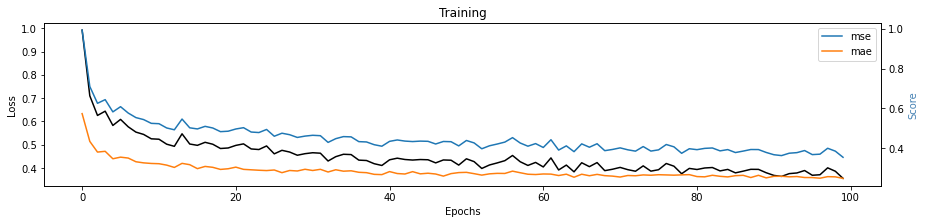

In [307]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharey=True, figsize=(15,3))
metrics = [k for k in training.history.keys() if ("loss" not in k) and ("val" not in k)]    

ax.set(title="Training")    
ax11 = ax.twinx()    
ax.plot(training.history['loss'], color='black')    
ax.set_xlabel('Epochs')    
ax.set_ylabel('Loss', color='black')    
for metric in metrics:        
    ax11.plot(training.history[metric], label=metric)    
    ax11.set_ylabel("Score", color='steelblue')    
ax11.legend()